In [ ]:
pip install kagglehub

In [ ]:
import kagglehub
import os
import shutil
import random
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [ ]:
# Baixar o dataset
path = kagglehub.dataset_download("arifmia/animal")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/arifmia/animal/versions/1


In [ ]:
# Listar os arquivos no diret√≥rio raiz do dataset
print("Arquivos no dataset_path: ", os.listdir(path))

# Criar diret√≥rios para classes espec√≠ficas
output_path = "./filtered_dataset/"
os.makedirs(os.path.join(output_path, "cat"), exist_ok=True)
os.makedirs(os.path.join(output_path, "dog"), exist_ok=True)


Arquivos no dataset_path:  ['Dataset']


In [ ]:
# Caminho para o diret√≥rio raiz do dataset
dataset_path = path + "/Dataset/train/"

# Listar todas as pastas no diret√≥rio raiz
animal_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

In [ ]:
# Contar as imagens em cada pasta
print("Pasta e n√∫mero de imagens:")
sufficient_images_folders = []
for folder in animal_folders:
    folder_path = os.path.join(dataset_path, folder)
    image_count = len([img for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))])

    print(f"{folder}: {image_count} imagens")

    if image_count >= 100:
        sufficient_images_folders.append(folder)

# Exibir as pastas com pelo menos 100 imagens
print("\nPastas com pelo menos 100 imagens:")
print(sufficient_images_folders)


Pasta e n√∫mero de imagens:
cat: 304 imagens
horse: 299 imagens
dog: 424 imagens

Pastas com pelo menos 100 imagens:
['cat', 'horse', 'dog']


In [ ]:
# Caminhos para os diret√≥rios das classes
cat_dir = os.path.join(dataset_path, "cat")
dog_dir = os.path.join(dataset_path, "dog")

# Copiar imagens filtradas para os novos diret√≥rios
for src_dir, class_name in [(cat_dir, "cat"), (dog_dir, "dog")]:
    dest_dir = os.path.join(output_path, class_name)
    for img_file in list(os.listdir(src_dir))[:100]:
        shutil.copy(os.path.join(src_dir, img_file), dest_dir)


In [ ]:
# Fun√ß√£o para redimensionar imagens
def resize_images(class_dir):
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        try:
            with Image.open(img_path) as img:
                img = img.resize((224, 224))  # Redimensionar para 224x224 pixels
                img.save(img_path)  # Salvar a imagem redimensionada
        except Exception as e:
            print(f"Erro ao processar {img_path}: {e}")

# Redimensionar imagens para ambas as classes
resize_images(os.path.join(output_path, "cat"))
resize_images(os.path.join(output_path, "dog"))


In [ ]:
# Verifique se o dataset est√° organizado e redimensionado corretamente
for class_name in ["cat", "dog"]:
    class_dir = os.path.join(output_path, class_name)
    print(f"{class_name} - Total imagens: {len(os.listdir(class_dir))}")

cat - Total imagens: 100
dog - Total imagens: 100


In [ ]:
# Data Augmentation para gerar mais imagens de treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Dividindo 80% treino e 20% valida√ß√£o
)

# Data Generator para o conjunto de treino
train_generator = train_datagen.flow_from_directory(
    output_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

# Data Generator para o conjunto de valida√ß√£o
validation_generator = train_datagen.flow_from_directory(
    output_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
# Confirmar n√∫mero de classes
print("Classes detectadas:", train_generator.class_indices)

Classes detectadas: {'cat': 0, 'dog': 1}


In [ ]:
# Modelo VGG16 pr√©-treinado
# Carregar modelo pr√©-treinado VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar apenas as √∫ltimas camadas para fine-tuning
for layer in base_model.layers[:-2]:
    layer.trainable = False


In [ ]:
# Adicionar camadas customizadas
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)  # Adicionado L2 Regularization
#x = Dropout(0.05)(x)  # Dropout para evitar overfitting
x = Dense(128, activation='relu')(x)
#x = Dense(128, activation='relu', kernel_regularizer=l2(0.00001))(x)
x = Dropout(0.25)(x)
#x = Dense(64, activation='relu')(x)
x = Dense(train_generator.num_classes, activation='softmax')(x)  # Sa√≠da com duas classes: 'cat' e 'dog'

In [ ]:
# Criar o modelo final
model = Model(inputs=base_model.input, outputs=x)

# Compilar o modelo com uma Learning Rate menor
#optimizer = Adam(learning_rate=0.00005)
optimizer = 'adam'
# Compilar o modelo
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks para evitar overfitting e ajustar a taxa de aprendizado
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.65, patience=3, min_lr=1e-4)

# Treinar o modelo com os geradores
model.fit(train_generator, validation_data=validation_generator, epochs=10, callbacks=[early_stopping, reduce_lr])

# Salvar os pesos do modelo
model.save("trained_model.keras")
print("Modelo salvo como 'trained_model.keras")

# Representa√ß√£o da estrutura e dos par√¢metros aprendidos que ser√£o usados ‚Äã‚Äãpara predi√ß√£o.
model.summary()

Epoch 1/10
10/10 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 427ms/step - accuracy: 0.8766 - loss: 0.5451 - val_accuracy: 0.8000 - val_loss: 0.8315 - learning_rate: 0.0010
Epoch 2/10
10/10 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 405ms/step - accuracy: 0.9436 - loss: 0.1494 - val_accuracy: 0.8750 - val_loss: 0.5723 - learning_rate: 0.0010
Epoch 3/10
10/10 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 281ms/step - accuracy: 0.9854 - loss: 0.0692 - val_accuracy: 0.9250 - val_loss: 0.4157 - learning_rate: 0.0010
Epoch 4/10
10/10 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 270ms/step - accuracy: 0.9745 - loss: 0.1428 - val_accuracy: 0.7750 - val_loss: 0.9221 - learning_rate: 0.0010
Epoch 5/10
10/10 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 275ms/step - accuracy: 0.9508 - loss: 0.1019 - val_accuracy: 0.9250 - val_loss: 0.4628 - learning_rate: 0.0010
Epoch 6/10
10/10 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

Model: "functional_13"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_11 (InputLayer)          ‚îÇ (None, 224, 224, 3)         ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_conv1 (Conv2D)                ‚îÇ (None, 224, 224, 64)        ‚îÇ           1,792 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_conv2 (Conv2D)                ‚îÇ (None, 224, 224, 64)        ‚îÇ          36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block1_pool (MaxPooling2D)           ‚îÇ (None, 112, 112, 64)        ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_conv1 (Conv2D)                ‚îÇ (None, 112, 112, 128)       ‚îÇ          73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_conv2 (Conv2D)                ‚îÇ (None, 112, 112, 128)       ‚îÇ         147,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block2_pool (MaxPooling2D)           ‚îÇ (None, 56, 56, 128)         ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv1 (Conv2D)                ‚îÇ (None, 56, 56, 256)         ‚îÇ         295,168 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv2 (Conv2D)                ‚îÇ (None, 56, 56, 256)         ‚îÇ         590,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ block3_conv3 (Conv2D)                ‚îÇ (None, 56, 56, 256)         ‚îÇ         590,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

 Total params: 38,802,120 (148.02 MB)

 Trainable params: 8,815,746 (33.63 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

 Optimizer params: 17,631,494 (67.26 MB)

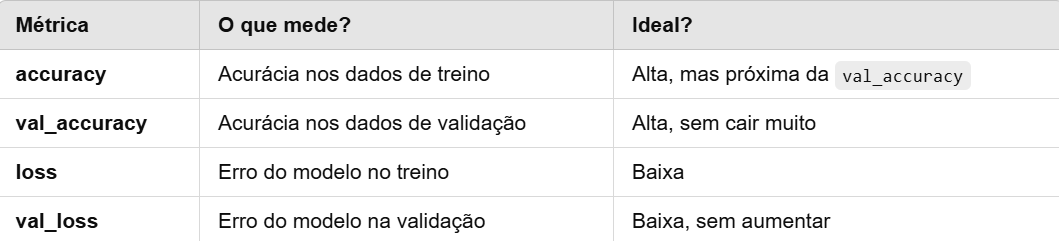



***1Ô∏è‚É£ Se a acur√°cia da valida√ß√£o come√ßar a cair:***

* Se a acur√°cia de treino for alta (ex: 99%), mas a de valida√ß√£o for muito menor e come√ßar a cair (ex: 85% ‚Üí 75%), o modelo est√° claramente overfitado e pode falhar em novos dados.

***2Ô∏è‚É£ Se a perda da valida√ß√£o (val_loss) aumentar enquanto a do treino cai:***

* Se loss no treino continuar diminuindo (0.1 ‚Üí 0.05 ‚Üí 0.02), mas val_loss aumentar (0.2 ‚Üí 0.4 ‚Üí 0.6), o modelo est√° memorizando os dados de treino e n√£o conseguir√° prever bem em novos dados.


*   Se loss e val_loss descem juntos ‚Üí O modelo est√° aprendendo bem.
*   Se loss desce, mas val_loss sobe ‚Üí O modelo est√° overfitting.
*   Se accuracy e val_accuracy sobem juntas ‚Üí O modelo est√° generalizando bem.


***Se precisar de ajustes no treinamento:***


*   Aumentar dropout para reduzir overfitting.
*   Aplicar data augmentation para melhorar a generaliza√ß√£o.
*   Treinar por mais √©pocas se o modelo ainda n√£o convergiu.

***üîß Ajustes Implementados***


*   Data Augmentation ‚Üí Aumenta a diversidade do dataset artificialmente.
*   Dropout (Regulariza√ß√£o) ‚Üí Evita que o modelo memorize padr√µes espec√≠ficos.
*   L2 Regularization ‚Üí Penaliza pesos muito grandes para melhorar a generaliza√ß√£o.
*   Early Stopping ‚Üí Para o treinamento quando o modelo para de melhorar.
*   Learning Rate Scheduling ‚Üí Ajusta a taxa de aprendizado ao longo do tempo.


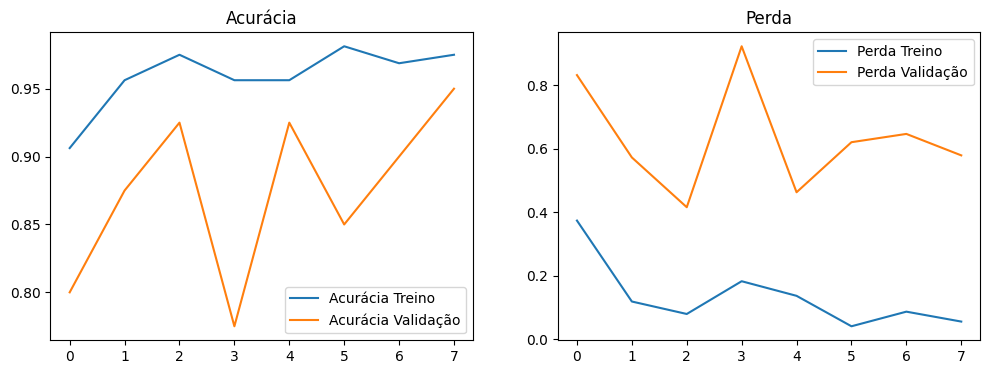

In [ ]:
# Plotando os resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

model_history = model.history

ax1.plot(model_history.history['accuracy'], label='Acur√°cia Treino')
ax1.plot(model_history.history['val_accuracy'], label='Acur√°cia Valida√ß√£o')
ax1.set_title('Acur√°cia')
ax1.legend()

ax2.plot(model_history.history['loss'], label='Perda Treino')
ax2.plot(model_history.history['val_loss'], label='Perda Valida√ß√£o')
ax2.set_title('Perda')
ax2.legend()

plt.show()

In [ ]:
# Carregar o modelo salvo para teste
modelo_carregado = load_model("trained_model.keras")
print("Modelo carregado para verifica√ß√£o")

Modelo carregado para verifica√ß√£o


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 43ms/step


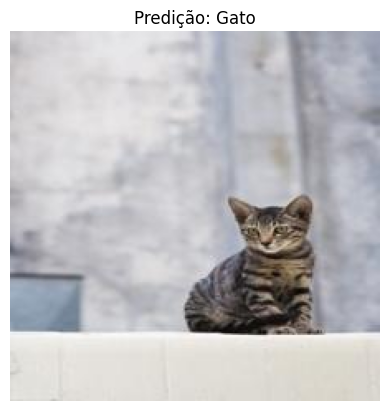

In [ ]:
# Caminho para a pasta com imagens de gatos
image_folder = "./filtered_dataset/cat"

# Escolher uma imagem aleat√≥ria dentro da pasta
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
if not image_files:
    raise ValueError("Nenhuma imagem encontrada na pasta!")

# Escolher uma imagem aleat√≥ria da lista
selected_image = np.random.choice(image_files)
image_path = os.path.join(image_folder, selected_image)

# Carregar e processar a imagem
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0  # Normalizar a imagem
img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimens√£o batch

# Fazer a predi√ß√£o com o modelo carregado
prediction = modelo_carregado.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)  # Obt√©m a classe com maior probabilidade

# Exibir a imagem e o resultado
plt.imshow(img)
plt.axis("off")
plt.title(f"Predi√ß√£o: {'Gato' if predicted_class[0] == 0 else 'Cachorro'}")
plt.show()